### MMDetection 설치
* 강의 영상에는 pip install mmcv-full로 mmcv를 설치(약 10분 정도의 시간이 소요)
* 실습코드는 pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu116/torch1.13/index.html 로 변경(설치에 12초 정도 걸림. 2022.09).
* 코랩의 pytorch 버전이 2.0으로 upgrade되었으나 mmdetection은 아직 pytorch 2.0을 지원하지 않기에 pytorch 1.13으로 downgrade 필요(2023.04월에 코랩 pytorch upgrade)
*  2023년 4월 6일 기준으로 mmdetection이 3.0으로 upgrade됨. 실습 코드는 mmdetection 2.x 기준으므로 mmdetection 2.x 소스코드 설치 필요.   

In [ ]:
#코랩의 pytorch 버전이 2.0으로 upgrade됨. 
import torch
print(torch.__version__)

In [ ]:
#현재 mmdetection이 pytorch 2.x를 지원하지 않음. pytorch 1.13+ CUDA 116 환경으로 코랩 커널 downgrade
# downgrade 설치시 ERROR: pip's dependency resolver... 부분은 신경쓰지 않아도 됨. 
!pip install torch==1.13.0+cu116 torchvision==0.14.0+cu116 --extra-index-url https://download.pytorch.org/whl/cu116

In [ ]:
# mmcv를 위해서 mmcv-full을 먼저 설치해야 함. https://mmcv.readthedocs.io/en/latest/get_started/installation.html 설치 과정 참조.
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu116/torch1.13/index.html

In [ ]:
# 2023년 4월 6일 기준으로 mmdetection이 3.0으로 upgrade됨. 실습 코드는 mmdetection 2.x 기준임. 
# mmdetection 2.x branch의 소스코드 기반으로 mmdetection 설치 필요. 
!git clone --branch 2.x https://github.com/open-mmlab/mmdetection.git
!cd mmdetection; python setup.py install

In [ ]:
# 런타임->런타임 다시 시작 후 아래 수행. 
from mmdet.apis import init_detector, inference_detector
import mmcv

In [ ]:
import torch

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

### Kaggle Nucleus Dataset을 다운로드 후 압축 해제
* 다운로드 받은 Nucleus Dataset은 이미지 id별로 개별 디렉토리를 가지고 그 하위에 images, masks 디렉토리를 가지고 있음.  

In [ ]:
!mkdir -p /content/nucleus
!wget https://github.com/chulminkw/DLCV/releases/download/1.0/stage1_train.zip
!echo "#### unzip stage1_train.zip"
!unzip stage1_train.zip -d /content/nucleus> /dev/null 2>&1

In [ ]:
import os
# 이미지 별로 고유한 이미지명을 가지는 이미지 디렉토리를 가지고 이 디렉토리에 하위 디렉토리로 images, masks를 가짐
# images 에는 하나의 이미지가 있으며 masks는 여러개의 mask 이미지 파일을 가지고 있음. 즉 하나의 이미지에 여러개의 mask 파일을 가지고 있는 형태임. 
# os.walk(direcotry)는 3개의 값을 반환 os.walk(direcotry)[0]을 directory와 file들이 있는 sub directory path를 반환. 
# next(os.walk(directory))[1]은 sub directory를 iteration으로 반환 next(os.walk(directory))[2]는 해당 디렉토리 밑에 파일들을 iteration으로 반환

DATA_ROOT_DIR = '/content/nucleus'
index = 0 
for dir in sorted(next(os.walk(DATA_ROOT_DIR))[1]):
    print('',dir)
    subdirs = os.path.join(DATA_ROOT_DIR, dir)
    for subdir in sorted(next(os.walk(subdirs))[1]):
        print('  |--'+subdir)
        sub_subdirs = os.path.join(subdirs, subdir)
        for sub_subdir in sorted(next(os.walk(sub_subdirs))[2]):
            print('       |-- '+sub_subdir)
            index += 1
            if index >1000:
                break

In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/content/mmdetection/configs'):
    print(dirname)
    for filename in filenames:
        print(os.path.join(dirname, filename))

### Nucleus 데이터 살펴보기 
* image 파일과 이에 매칭되는 mask 파일을 시각화 
* image id, image와 mask 파일 절대 경로를 OS 디렉토리 구조에서 추출하는 함수 생성. 

In [ ]:
import matplotlib.pyplot as plt
import cv2

image_file_name = '/content/nucleus/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/images/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png'
#image_file_name = '/content/nucleus/df53d0b6c2c4e45d759b2c474011e2b2b32552cd100ca4b22388ab9ca1750ee2/images/df53d0b6c2c4e45d759b2c474011e2b2b32552cd100ca4b22388ab9ca1750ee2.png'
mask_file_list = [
                  '/content/nucleus/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/07a9bf1d7594af2763c86e93f05d22c4d5181353c6d3ab30a345b908ffe5aadc.png',
                  '/content/nucleus/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/0e548d0af63ab451616f082eb56bde13eb71f73dfda92a03fbe88ad42ebb4881.png',
                  '/content/nucleus/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/0ea1f9e30124e4aef1407af239ff42fd6f5753c09b4c5cac5d08023c328d7f05.png',
                  '/content/nucleus/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/0f5a3252d05ecdf453bdd5e6ad5322c454d8ec2d13ef0f0bf45a6f6db45b5639.png',
                  '/content/nucleus/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/2c47735510ef91a11fde42b317829cee5fc04d05a797b90008803d7151951d58.png'
                  ]
                  
def show_image_masks(image_file_name, mask_file_list, cols=6):
  figure, axs = plt.subplots(nrows=1, ncols=cols, figsize=(16, 12))
  for i in range(cols):
    im_name = image_file_name if i ==0 else mask_file_list[i-1]
    im_array = cv2.cvtColor(cv2.imread(im_name), cv2.COLOR_BGR2RGB)
    print('{0:} shape:{1:}'.format('image' if i == 0 else 'mask', im_array.shape))
    axs[i].imshow(im_array)
    axs[i].set_title('image' if i == 0 else 'mask'+str(i))

show_image_masks(image_file_name, mask_file_list)


In [ ]:
DATA_ROOT_DIR = '/content/nucleus'

# 디렉토리 형태인 모든 image id를 list로 추출. 
def get_imageid_list(data_root_dir):
  imageid_list = []
  # data_root_dir 밑에 있는 모든 sub directory 명을 추출. 
  for imageid in sorted(next(os.walk(data_root_dir))[1]):
      imageid_list.append(imageid)

  return imageid_list

# 모든 image 파일의 절대경로를 list로 추출. 
def get_imagename_list(data_root_dir):
  imagename_list = []
  # data_root_dir 밑에 있는 모든 image id 디렉토리의 서브 디렉토리 중 images 디렉토리 밑에 있는 image 파일 명을 절대 경로로 추출
  # data_root_dir -> image id dir -> images -> image 파일명 
  for dir in sorted(next(os.walk(data_root_dir))[1]):
      subdirs = os.path.join(data_root_dir, dir)
      image_dir = os.path.join(subdirs, 'images')
      for imagename in sorted(next(os.walk(image_dir))[2]):
        imagename_list.append(os.path.join(image_dir, imagename))
        
  return imagename_list

# 특정 image id 디렉토리 밑에 있는 mask 파일명을 절대 경로로 모두 추출.
# image_id dir -> masks -> 여러 mask 파일 명 
def get_maskname_list(image_id_dir):
  mask_dir = os.path.join(image_id_dir, 'masks')
  maskname_list = []
  for mask_filename in next(os.walk(mask_dir))[2]:
    if '.png' in mask_filename:
      maskname_list.append(os.path.join(mask_dir, mask_filename))
  
  return maskname_list


imageid_list = get_imageid_list(DATA_ROOT_DIR)
print('##### image id list #####')
for imageid in imageid_list[:3]:
  print(imageid)

maskname_list = get_maskname_list(os.path.join(DATA_ROOT_DIR, imageid_list[0]))
print('##### mask name list #####')
for maskname in maskname_list[:3]:
  print(maskname)

imagename_list = get_imagename_list(DATA_ROOT_DIR)
print('##### image name list #####')
for imagename in imagename_list[:3]:
  print(imagename)

In [ ]:
maskname_list = get_maskname_list(os.path.join(DATA_ROOT_DIR, imageid_list[1]))
show_image_masks(imagename_list[1],  maskname_list[:5], cols=6)

### Nucleus image의 유형별 분류 시각화
* brightfield/stained/fluorescence 와 같은 형태로 이미지가 부여됨
* 개별 이미지의 Hue(색상), Saturation(채도), Value(명도) 값에 따른 image clustering으로 유형별 분류


In [ ]:
from sklearn.cluster import KMeans

# 개별 이미지의 hsv array
image_file_name = '/content/nucleus/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/images/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png'
img_hsv = cv2.cvtColor(cv2.imread(image_file_name), cv2.COLOR_BGR2HSV)

# 단일 이미지의 픽셀값을 KMeans로 Clustering 하여 중심 centroid를 반환. 먼저 Kmeans 이용시 2d array 변환. 
img_hsv_2d = img_hsv.reshape((img_hsv.shape[0] * img_hsv.shape[1], img_hsv.shape[2]))
clt = KMeans(n_clusters = 1)
clt.fit(img_hsv_2d)
print('img hsv cluster_center:', clt.cluster_centers_)
print('img hsv array:', img_hsv_2d)

In [ ]:
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm
import numpy as np

# 단일 이미지의 픽셀값을 KMeans로 Clustering 하여 중심 centroid를 반환. 
def get_cluster_center(img_hsv, n_cluster=1):
    # KMeans에 입력되기 위해서는 2d array가 되어야 함. 3d image array를 2d로 변환. 
    img_hsv_2d = img_hsv.reshape((img_hsv.shape[0] * img_hsv.shape[1], img_hsv.shape[2]))
    
    # 단일 이미지의 픽셀값 정보를 KMeans로 clustering 적용. 
    kmeans = KMeans(n_clusters = n_cluster)
    kmeans.fit(img_hsv_2d)
    # cluster 중심점 반환. 
    return kmeans.cluster_centers_ 

# image_name_list에 있는 모든 image 파일들의 중심 centroid 데이터 세트를 기반으로 3개의 clustering을 수행. 
def cluster_images_by_hsv(image_name_list, hsv_clusters=3):
    hsv_centers = []
    # image_name_list에 있는 image 파일들을 HSV 형태로 변환한 뒤, 개별 중심 Centroid를 구함. 
    for img_filename in tqdm(image_name_list):
      img_hsv = cv2.cvtColor(cv2.imread(img_filename), cv2.COLOR_BGR2HSV)
      cluster_center = get_cluster_center(img_hsv, n_cluster=1)
      # 중심 centroid정보는 2차원임. 이를 1차원으로 변환하고 hsv_centers에 추가. 
      hsv_centers.append(cluster_center.squeeze())
    # 모든 image에 대한 중심 centroid를 기반으로 3개의 군집화 수행. 
    hsv_centers_arr = np.array(hsv_centers)
    kmeans = KMeans(n_clusters=hsv_clusters).fit(hsv_centers_arr)
    # 모든 중심 centroid에 대해서 군집 결과(0, 1, 2) 예측 
    cluster_results = kmeans.predict(hsv_centers_arr)

    return cluster_results


In [ ]:
pred_clusters = cluster_images_by_hsv(imagename_list, hsv_clusters=3)
print(pred_clusters, len(pred_clusters))

### image id와 image 절대 경로, mask 파일의 절대 경로, hsv cluster 결과값을 한번에 볼 수 있는 DataFrame 생성. 
* DataFrame기반의 meta 정보 생성. 
* 해당 DataFrame으로 이미지 시각화 
* 해당 DataFrame을 기반으로 train과 validation 용 image id 분리

In [ ]:
import pandas as pd

def make_meta_df(dataset_dir):
  # 모든 image id들의 list를 가져옴. 
  imageid_list = get_imageid_list(dataset_dir)
  # 모든 image 절대경로들의 list를 가져옴. 
  imagename_list = get_imagename_list(dataset_dir)
  # 개별 image당 모든 mask 절대 경로를 가져옴. 
  maskname_list_list = []
  for imageid in imageid_list:
    maskname_list = get_maskname_list(os.path.join(dataset_dir, imageid))
    maskname_list_list.append(maskname_list)

  # 모든 이미지에 대해서 HSV 기반의 Clustering 적용
  pred_clusters = cluster_images_by_hsv(imagename_list, hsv_clusters=3)
  meta_df = pd.DataFrame({'image_id': imageid_list,
                          'image_name': imagename_list,
                          'maskname_list': maskname_list_list,
                          'hsv_cluster': pred_clusters})
  return meta_df

meta_df = make_meta_df(DATA_ROOT_DIR)

In [ ]:
pd.set_option('display.max_colwidth', 300)
meta_df.head(3)

In [ ]:
# hsv_cluster 유형에 따른 image와 mask 시각화. 
# 특정 hsv_cluster값으로 1개의 image와 이에 해당하는 mask 절대경로 추출. 
img_name_mask_df = meta_df[meta_df['hsv_cluster'] == 0][['image_name', 'maskname_list']].iloc[0, :]
imagename = img_name_mask_df['image_name']
maskname_list = img_name_mask_df['maskname_list']
print(imagename)
print(maskname_list)

show_image_masks(imagename, maskname_list[:5], cols=6)

In [ ]:
# 특정 hsv_cluster 값에 따라 여러개의 image들을 시각화
imagenames = meta_df[meta_df['hsv_cluster'] == 2]['image_name'].to_list()
figure, axs = plt.subplots(nrows=1, ncols=6, figsize=(16, 12))
for i in range(6):
  axs[i].imshow(cv2.cvtColor(cv2.imread(imagenames[i]), cv2.COLOR_BGR2RGB))
  

### mask 이미지 파일을 기반으로 segmentation polygon과 bbox정보를 추출
* opencv의 findContours()를 이용하여 외곽선 정보 추출하고, 이를 기반으로 coco segmentation polygon 생성
* segmentation 정보를 기반으로 bbox 정보 생성. 

In [ ]:
import matplotlib.pyplot as plt
import cv2

mask_file ='/content/nucleus/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/07a9bf1d7594af2763c86e93f05d22c4d5181353c6d3ab30a345b908ffe5aadc.png'
mask_array = cv2.imread(mask_file)
print(mask_array.shape)
plt.imshow(mask_array)

In [ ]:
# findCountours()로 mask의 외곽선 좌표 추출. findContours()는 2차원 array로 입력 받을 수 있으므로 3차원 mask를 2차원으로 변환하여 입력.
contours, hierarchy = cv2.findContours(mask_array[:, :, 0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#contours = [contour for contour in contours if contour.shape[0] > 2]
print(contours)

In [ ]:
contours[0].shape

In [ ]:
contoured_mask_array = cv2.drawContours(mask_array, contours, -1, (0, 255, 0), 2, cv2.LINE_8, hierarchy, 100)
plt.imshow(contoured_mask_array)

In [ ]:
# ravel()은 다차원을 1차원으로 변환. 
a1 = np.array([[1,2],
               [3,4]])
a1.ravel()

In [ ]:
print([s.ravel().tolist() for s in contours])

In [ ]:
mask_array = cv2.imread('/content/nucleus/ddf1bf458312de2895dd9cc5ce7ec9d334ad54c35edc96ad6001d20b1d8588d8/masks/5c69eea1e0d21c5973180d464a5ed62572d953a3917bb95d8e8c71915b29a194.png')
contours, hierarchy = cv2.findContours(mask_array[:, :, 0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if contours[0].shape[0] <= 2:
  print('####### contours[0] shape is less than 2 #######')
polygon = [s.ravel().tolist() for s in contours]
print(polygon)

In [ ]:
# bounding box 정보를 polygon에서 추출. 
def get_bbox(segm):
  x_min = float("inf")
  y_min = float("inf")
  x_max = 0
  y_max = 0
  for s in segm:
    #segmentation polygon정보로 bounding box 정보 추출. 
    x, y, w, h = cv2.boundingRect(s)
    x_b = x + w
    y_b = y + h
    # 최소 0보다 크고, 무한대 보다는 좌표값이 작아야 함. 
    x_min = min(x_min, x)
    y_min = min(y_min, y)
    x_max = max(x_max, x_b)
    y_max = max(y_max, y_b)

  # 좌상단 좌표와, width, height 반환. 
  return x_min, y_min, x_max - x_min, y_max - y_min


In [ ]:
# mask image를 기반으로 segmentation polygon과 bbox 정보를 추출하는 로직 함수화
def get_annotation_info(mask_dir, mask_filename):
  mask_array = cv2.imread(os.path.join(mask_dir, mask_filename))
  contours, hierarchy = cv2.findContours(mask_array[:, :, 0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  segm = [contour for contour in contours if contour.shape[0] > 2]
  polygons = [s.ravel().tolist() for s in contours]
  #check_polygon(polygons, mask_array.shape[0], mask_array.shape[1])
  xmin, ymin, bwidth, bheight = get_bbox(segm)
  return polygons, [xmin, ymin, bwidth, bheight]

polygons, bbox = get_annotation_info('/content/nucleus/ddf1bf458312de2895dd9cc5ce7ec9d334ad54c35edc96ad6001d20b1d8588d8/masks', 
                                     '5c69eea1e0d21c5973180d464a5ed62572d953a3917bb95d8e8c71915b29a194.png')
print(polygons, bbox)

### coco 포맷으로 변환하기

* images id 디렉토리를 기반으로 image_id 생성. 
* 개별 image id의 images 디렉토리에서 개별 image 파일의 width, height 추출
* 개별 image id의 masks 디렉토리에서 여러 mask 파일들을 get_anntotation_info()로 polygon 형태의 segmentation과 bbox 정보 추출
* 개별 object의 id는 0부터 증가하는 순차적인 index로 생성.
* 별도의 coco image와 json 생성을 위한 디렉토리를 생성하고, meta_df를 이용하여 train, valid 용 coco json 생성. 


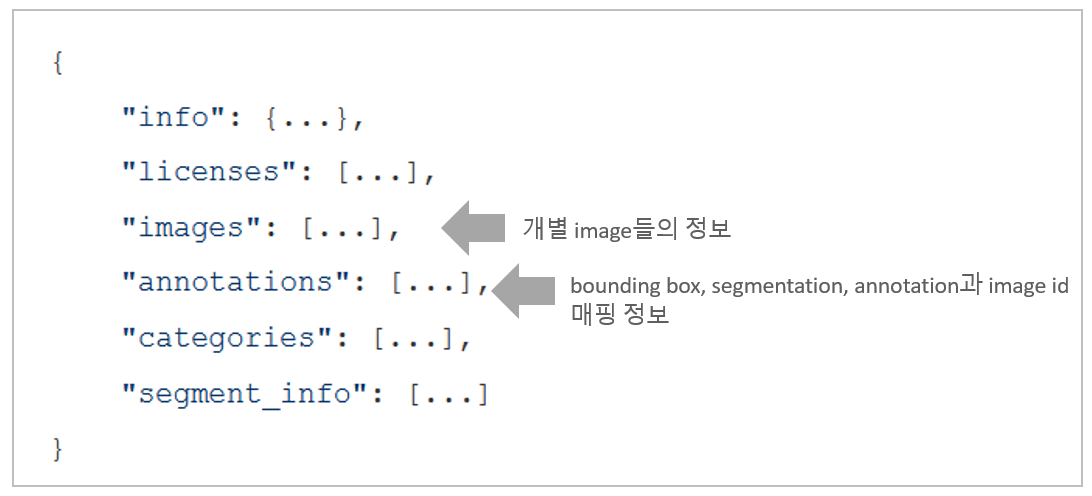

In [ ]:
import cv2
import json

def convert_nucleus_to_coco(data_root_dir, image_ids, out_file):
  
  images = []
  annotations = []
  categories = []
  obj_index = 0
  # image 정보를 담아서 images list에 추가. 
  for image_id in image_ids:
    image_id_dir = os.path.join(data_root_dir, image_id)
    image_path = os.path.join(image_id_dir, 'images/' + image_id + '.png')
    file_name = image_id + '.png'
    height, width = cv2.imread(image_path).shape[0:2] 
    # 개별 image의 dict 정보 생성
    image_info = dict(file_name=file_name,
                      height=height,
                      width=width,
                      id=image_id)
    # 개별 image dict 정보를 images list에 추가. 
    images.append(image_info)

    # 개별 image에 있는 여러 mask 이미지 파일을 segmentation, bbox로 변환하여 annotation dict 정보 생성. 
    mask_dir = os.path.join(image_id_dir, 'masks')
    mask_filename_list = next(os.walk(mask_dir))[2]
    # 개별 image에 있는 여러 mask 이미지 파일을 기반으로 annotation dict 생성. 
    for mask_filename in mask_filename_list:
      # 개별 mask 파일에서 polygon list와 bbbox list를 계산하여 반환.  
      segmentation, bbox = get_annotation_info(mask_dir, mask_filename)
      
      # 만일 segmentation이 None이면 coco 데이터로 만들지 않음. 
      if segmentation is None:
        continue
      annotation = dict(segmentation=segmentation,
                        area=bbox[2]*bbox[3] , # 반드시 계산 필요.
                        iscrowd=0,
                        bbox=bbox,
                        category_id=0,
                        image_id=image_id,
                        id = obj_index)
      # 계산된 annotation dict 정보를 annotations list에 추가. 
      annotations.append(annotation)
      # object 고유 id 증가. 
      obj_index += 1
    print('image id:', image_id, 'annotation is done')
  
  # images 와 annotations, categories list를 최종 Dict로 변환하고 json 형식으로 출력. 
  coco_format_json = dict(
    images = images,
    annotations = annotations,
    categories = [{'id':0, 'name':'nucleus'}]
    )
  
  # json 파일로 출력. 
  #mmcv.dump(coco_format_json, out_file)
  with open(out_file, 'w') as json_out_file:
    json.dump(coco_format_json, json_out_file)

In [ ]:
# https://github.com/open-mmlab/mmdetection/blob/master/mmdet/datasets/pipelines/loading.py def _poly2mask(self, mask_ann, img_h, img_w):
import pycocotools.mask as maskUtils

def check_polygons(mask_filepath, polygons, img_h, img_w):
  try:
    rles = maskUtils.frPyObjects(polygons, img_h, img_w)
    rle = maskUtils.merge(rles)
  except Exception as e:
    print('##### 오류 polygon 발생 #####:',  e,polygons)
    print('오류 mask file명:', mask_filepath)

In [ ]:
# mask image를 기반으로 segmentation polygon과 bbox 정보를 추출하는 로직 함수화
def get_annotation_info(mask_dir, mask_filename):
  mask_filepath = os.path.join(mask_dir, mask_filename)
  mask_array = cv2.imread(mask_filepath)
  contours, hierarchy = cv2.findContours(mask_array[:, :, 0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  segm = [contour for contour in contours if contour.shape[0] > 2]
  polygons = [s.ravel().tolist() for s in contours]
  #polygons = [s.ravel().tolist() for s in segm]
  check_polygons(mask_filepath, polygons, mask_array.shape[0], mask_array.shape[1])
  xmin, ymin, bwidth, bheight = get_bbox(segm)
  # 만약 polygons가 Null이면 segmentation과 bbox annotation을 None으로 반환. 
  if polygons == []:
    return None, None 
  # polygons가 Null이 아니면 정상적으로 segmentation과 bbox annotation 반환. 
  else: 
    return polygons, [xmin, ymin, bwidth, bheight]


In [ ]:
!mkdir /content/coco_output

In [ ]:
# 학습과 검증용 image id 데이터들을 추출. 
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(meta_df, test_size=0.1, stratify=meta_df['hsv_cluster'], random_state=2021)

train_ids = train_df['image_id'].to_list()
val_ids = val_df['image_id'].to_list()

In [ ]:
convert_nucleus_to_coco('/content/nucleus', train_ids, '/content/coco_output/train_coco.json')
convert_nucleus_to_coco('/content/nucleus', val_ids, '/content/coco_output/val_coco.json')

In [ ]:
!sudo apt-get install jq
!jq . /content/coco_output/val_coco.json > output_val_coco.json

In [ ]:
import cv2
import json
import shutil

# mmdetection config에 맞추기 위해 nucleus 이미지 파일을 별도의 디렉토리로 이동하는 로직 추가 
def convert_nucleus_to_coco(data_root_dir, image_ids, out_file, img_copy_dir):
  
  images = []
  annotations = []
  categories = []
  obj_index = 0
  # image 정보를 담아서 images list에 추가. 
  for image_id in image_ids:
    image_id_dir = os.path.join(data_root_dir, image_id)
    image_path = os.path.join(image_id_dir, 'images/' + image_id + '.png')
    file_name = image_id + '.png'
    height, width = cv2.imread(image_path).shape[0:2] 
    # 개별 image의 dict 정보 생성
    image_info = dict(file_name=file_name,
                      height=height,
                      width=width,
                      id=image_id)
    # 개별 image dict 정보를 images list에 추가. 
    images.append(image_info)

    # 이미지를 특정 디렉토리 밑으로 모일 수 있도록 copy
    shutil.copy(image_path, os.path.join(img_copy_dir, file_name))

    # 개별 image에 있는 여러 mask 이미지 파일을 segmentation, bbox로 변환하여 annotation dict 정보 생성. 
    mask_dir = os.path.join(image_id_dir, 'masks')
    mask_filename_list = next(os.walk(mask_dir))[2]
    # 개별 image에 있는 여러 mask 이미지 파일을 기반으로 annotation dict 생성. 
    for mask_filename in mask_filename_list:
      # 개별 mask 파일에서 polygon list와 bbbox list를 계산하여 반환.  
      segmentation, bbox = get_annotation_info(mask_dir, mask_filename)
      
      # 만일 segmentation이 None이면 coco 데이터로 만들지 않음. 
      if segmentation is None:
        continue
      annotation = dict(segmentation=segmentation,
                        area=bbox[2] * bbox[3] , # 굳이 area를 계산할 필요가 없어서 0 처리
                        iscrowd=0,
                        bbox=bbox,
                        category_id=0,
                        image_id=image_id,
                        id = obj_index)
      # 계산된 annotation dict 정보를 annotations list에 추가. 
      annotations.append(annotation)
      # object 고유 id 증가. 
      obj_index += 1
    print('image id:', image_id, 'annotation is done')
  
  coco_format_json = dict(
    images = images,
    annotations = annotations,
    categories = [{'id':0, 'name':'nucleus'}]
    )
  
  # json 파일로 출력. 
  #mmcv.dump(coco_format_json, out_file)
  with open(out_file, 'w') as json_out_file:
    json.dump(coco_format_json, json_out_file)

In [ ]:
!mkdir -p /content/coco_output/train
!mkdir -p /content/coco_output/val

convert_nucleus_to_coco('/content/nucleus', train_ids, '/content/coco_output/train_coco.json', '/content/coco_output/train')
convert_nucleus_to_coco('/content/nucleus', val_ids, '/content/coco_output/val_coco.json', '/content/coco_output/val')

### pycocotools를 이용하여 변환된 coco json의 segmentation 시각화
* coco format으로 잘 변환되었는지 확인하기 위해 pycocotools로 특정 image id의 image filename및 segmentation 정보를 추출한 뒤 이를 시각화 

In [ ]:
from pycocotools.coco import COCO

coco_val = COCO('/content/coco_output/val_coco.json')

In [ ]:
# category id와 image id 출력. 
catIds = coco_val.getCatIds(catNms=['nucleus']);
print(catIds)
# oco.getImgIds(catIds=catIds)는 해당 catogory id별로 한개의 image id을 임의로 출력
imgIds =coco_val.getImgIds(catIds=catIds )
print(imgIds)
print(len(imgIds))

In [ ]:
# image id에 대한 image 정보와 해당 image의 object별에 annotation 정보 추출. 
img = coco_val.loadImgs(val_ids)[0]
print(img['id'])
annIds = coco_val.getAnnIds(imgIds=[img['id']], catIds=[0], iscrowd=None)
print(annIds)
anns = coco_val.loadAnns(annIds)
print(anns)
print(len(anns))

In [ ]:
import numpy as np

# coco data 실습에 사용된 시각화 함수를 그대로 가져옴. 
def get_polygon_xy(ann_seg):
  polygon_x = [x for index, x in enumerate(ann_seg) if index % 2 == 0]
  polygon_y = [x for index, x in enumerate(ann_seg) if index % 2 == 1]
  polygon_xy = [[x, y] for x, y in zip(polygon_x, polygon_y)]
  polygon_xy = np.array(polygon_xy, np.int32)
  return polygon_xy

def get_mask(image_array_shape, polygon_xy):
  mask = np.zeros(image_array_shape)
  masked_polygon = cv2.fillPoly(mask, [polygon_xy], 1)
  
  return masked_polygon

def apply_mask(image, mask, color, alpha=0.5):
  for c in range(3):
    image[:, :, c] = np.where(mask == 1,
                              image[:, :, c] *
                              (1 - alpha) + alpha * color[c] * 255,
                              image[:, :, c])
  return image

# ann_seg_list에 있는 object들의 segmentation에 따라 instance segmentation 시각화. 
def draw_segment(image_array, ann_seg_list, color_list, alpha):
  draw_image = image_array.copy()
  mask_array_shape = draw_image.shape[0:2]

  # list형태로 입력된 segmentation 정보들을 각각 시각화
  for index, ann_seg in enumerate(ann_seg_list):
    # polygon 좌표로 변환. 
    polygon_xy = get_polygon_xy(ann_seg)
    # mask 정보 변환
    masked_polygon = get_mask(mask_array_shape, polygon_xy)

    # segmentation color와 외곽선용 color 선택 
    color_object = color_list[np.random.randint(len(color_list))]
    color_contour = color_list[np.random.randint(len(color_list))]
    # masking 적용. 
    masked_image = apply_mask(draw_image, masked_polygon, color_object, alpha=0.6)
    # 외곽선 적용. 
    s_mask_int = (masked_polygon*255).astype("uint8")
    contours, hierarchy = cv2.findContours(s_mask_int, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    masked_image = cv2.drawContours(masked_image, contours, -1, color_contour, 1, cv2.LINE_8, hierarchy, 100)

  return masked_image

In [ ]:
color_list = [
              (0, 255, 0),
              (255, 0, 0),
              (0, 0, 255)
]
anns = coco_val.loadAnns(annIds)
# segmentation 정보만 별도로 추출. 
ann_seg_list = [ann['segmentation'][0] for ann in anns]
print(ann_seg_list)
print(len(ann_seg_list))

In [ ]:
import matplotlib.pyplot as plt
import cv2

# 원본 이미지 시각화 
val_image_id = val_df['image_id'].iloc[0]
print(val_image_id)

annIds = coco_val.getAnnIds(imgIds=[val_image_id], catIds=[0], iscrowd=None)
anns = coco_val.loadAnns(annIds)
# segmentation 정보만 별도로 추출. 
ann_seg_list = [ann['segmentation'][0] for ann in anns]

val_image_name = val_df[val_df['image_id']==val_image_id]['image_name'].to_list()
image_array = cv2.cvtColor(cv2.imread(val_image_name[0]), cv2.COLOR_BGR2RGB)

# coco segmentation 정보를 기반으로 segmentation 적용한 이미지 시각화 
masked_image = draw_segment(image_array, ann_seg_list, color_list, alpha=0.6)
plt.figure(figsize=(6, 6))
plt.imshow(masked_image)
plt.axis('off')

In [ ]:
def get_coco_masked_image(coco, image_id, image_name):
  annIds = coco.getAnnIds(imgIds=[image_id], catIds=[0], iscrowd=None)
  anns = coco.loadAnns(annIds)
  # segmentation 정보만 별도로 추출. 
  ann_seg_list = [ann['segmentation'][0] for ann in anns]

  image_array = cv2.cvtColor(cv2.imread(image_name), cv2.COLOR_BGR2RGB)

  # coco segmentation 정보를 기반으로 segmentation 적용한 이미지 시각화 
  masked_image = draw_segment(image_array, ann_seg_list, color_list, alpha=0.6)

  return masked_image

def show_coco_masked_image(coco, data_df, image_id_list, cols=5):

  figure, axs = plt.subplots(nrows=1, ncols=cols, figsize=(16, 12))
  for i in range(cols):
    image_id = image_id_list[i]
    image_name = data_df[data_df['image_id'] == image_id]['image_name'].to_list()[0]
    masked_image = get_coco_masked_image(coco, image_id, image_name)

    axs[i].imshow(masked_image)

def show_coco_image(data_df, image_id_list, cols=5):

  figure, axs = plt.subplots(nrows=1, ncols=cols, figsize=(16, 12))
  for i in range(cols):
    image_id = image_id_list[i]
    image_name = data_df[data_df['image_id'] == image_id]['image_name'].to_list()[0]
    
    axs[i].imshow(cv2.cvtColor(cv2.imread(image_name), cv2.COLOR_BGR2RGB))

coco_train = COCO('/content/coco_output/train_coco.json')
coco_val= COCO('/content/coco_output/val_coco.json')

show_coco_image(val_df, val_ids[0:5], cols=5)  
show_coco_masked_image(coco_val, val_df, val_ids[0:5], cols=5)


In [ ]:
show_coco_image(train_df, train_ids[0:5], cols=5)  
show_coco_masked_image(coco_train, train_df, train_ids[0:5], cols=5)

### Pretrained 모델 다운로드, Config 설정

In [ ]:
# pretrained weight 모델을 다운로드 받기 위해서 mmdetection/checkpoints 디렉토리를 만듬. 
!cd mmdetection; mkdir checkpoints

In [ ]:
!wget -O /content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth http://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r101_fpn_1x_coco/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth

In [ ]:
!ls -lia /content/mmdetection/checkpoints

In [ ]:
# config 파일을 설정하고, 다운로드 받은 pretrained 모델을 checkpoint로 설정. 
config_file = '/content/mmdetection/configs/mask_rcnn/mask_rcnn_r101_fpn_1x_coco.py'
checkpoint_file = '/content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth'

In [ ]:
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.coco import CocoDataset

@DATASETS.register_module(force=True)
class NucleusDataset(CocoDataset):
  CLASSES = ['nucleus']

In [ ]:
from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

In [ ]:
from mmdet.apis import set_random_seed

# dataset에 대한 환경 파라미터 수정. 
cfg.dataset_type = 'NucleusDataset'
cfg.data_root = '/content/coco_output/'

# train, val, test dataset에 대한 type, data_root, ann_file, img_prefix 환경 파라미터 수정. 
cfg.data.train.type = 'NucleusDataset'
cfg.data.train.data_root = '/content/coco_output/'
cfg.data.train.ann_file = 'train_coco.json'
cfg.data.train.img_prefix = 'train'

cfg.data.val.type = 'NucleusDataset'
cfg.data.val.data_root = '/content/coco_output/'
cfg.data.val.ann_file = 'val_coco.json'
cfg.data.val.img_prefix = 'val'

# class의 갯수 수정. 
cfg.model.roi_head.bbox_head.num_classes = 1
cfg.model.roi_head.mask_head.num_classes = 1

# pretrained 모델
cfg.load_from = '/content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth'

# 학습 weight 파일로 로그를 저장하기 위한 디렉토리 설정. 
cfg.work_dir = './tutorial_exps'

# 학습율 변경 환경 파라미터 설정. 
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# CocoDataset의 경우 metric을 bbox로 설정해야 함.(mAP아님. bbox로 설정하면 mAP를 iou threshold를 0.5 ~ 0.95까지 변경하면서 측정)
cfg.evaluation.metric = ['bbox', 'segm']
cfg.evaluation.interval = 12
cfg.checkpoint_config.interval = 12

# epochs 횟수는 36으로 증가 
#cfg.runner.max_epochs = 36 

# 두번 config를 로드하면 lr_config의 policy가 사라지는 오류로 인하여 설정. 
cfg.lr_config.policy='step'
# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)


# ConfigDict' object has no attribute 'device 오류 발생시 반드시 설정 필요. https://github.com/open-mmlab/mmdetection/issues/7901
cfg.device='cuda'

In [ ]:
print(cfg.pretty_text)

### 데이터 세트 내부 변수 값 확인 및 Train 수행
* build_dataset(config)로 생성된 Dataset의 내부 변수값을 확인. 

In [ ]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# train, valid 용 Dataset 생성. 
datasets_train = [build_dataset(cfg.data.train)]
datasets_val = [build_dataset(cfg.data.val)]

In [ ]:
datasets_train 

In [ ]:
print(datasets_train[0])
print(datasets_val[0])

In [ ]:
datasets_train[0].data_infos

In [ ]:
datasets_train[0].__dict__.keys()

In [ ]:
datasets_train[0].img_prefix, datasets_train[0].data_root, datasets_train[0].ann_file

In [ ]:
datasets_train[0].pipeline

In [ ]:
model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
model.CLASSES = datasets_train[0].CLASSES
print(model.CLASSES)

In [ ]:
import os.path as osp
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
# epochs는 config의 runner 파라미터로 지정됨. 기본 12회 
train_detector(model, datasets_train, cfg, distributed=False, validate=True)

In [ ]:
!ls -lia /content/tutorial_exps

### Inference 수행. 

In [ ]:
from mmdet.apis import inference_detector, show_result_pyplot

checkpoint_file = '/content/tutorial_exps/epoch_12.pth'

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_detector(cfg, checkpoint_file, device='cuda:0')

In [ ]:
val_img_name = val_df['image_name'].iloc[0]
print(val_img_name)

# BGR Image 사용 
img_arr = cv2.imread(val_img_name)
#model_ckpt.cfg = cfg

results = inference_detector(model_ckpt, img_arr)
show_result_pyplot(model_ckpt, img_arr, results, score_thr=0.1)

In [ ]:
results[1]

In [ ]:
#print(results[0])
print(results[0][0].shape)
#print(results[1])
print(len(results[1][0]))
print(results[1][0][0].shape)

### show_result_pyplot()을 사용하지 않고, inference 이미지 Custom 시각화

In [ ]:
import numpy as np

labels_to_names_seq =  {0:'nucleus'}
  
COLORS = list(
    [[0, 255, 0],
     [0, 0, 255],
     [255, 0, 0],
     [0, 255, 255],
     [255, 255, 0],
     [255, 0, 255],
     [80, 70, 180],
     [250, 80, 190],
     [245, 145, 50],
     [70, 150, 250]] )

In [ ]:
# model과 원본 이미지 array, filtering할 기준 class confidence score를 인자로 가지는 inference 시각화용 함수 생성. 
# 이미 inference 시 mask boolean값이 들어오므로 mask_threshold 값을 필요하지 않음. 
def get_detected_img(model, img_array,  score_threshold=0.3, draw_box=True, is_print=True):
  # 인자로 들어온 image_array를 복사. 
  draw_img = img_array.copy()
  bbox_color=(0, 255, 0)
  text_color=(0, 0, 255)

  # model과 image array를 입력 인자로 inference detection 수행하고 결과를 results로 받음.  
  results = inference_detector(model, img_array)
  bbox_results = results[0]
  seg_results = results[1]

  # results 리스트를 loop를 돌면서 개별 2차원 array들을 추출하고 이를 기반으로 이미지 시각화 
  # results 리스트의 위치 index가 매핑된 Class id. 여기서는 result_ind가 class id
  # 개별 2차원 array에 오브젝트별 좌표와 class confidence score 값을 가짐. 
  for result_ind, bbox_result in enumerate(bbox_results):
    # 개별 2차원 array의 row size가 0 이면 해당 Class id로 값이 없으므로 다음 loop로 진행. 
    if len(bbox_result) == 0:
      continue
    
    mask_array_list = seg_results[result_ind]
    
    # 해당 클래스 별로 Detect된 여러개의 오브젝트 정보가 2차원 array에 담겨 있으며, 이 2차원 array를 row수만큼 iteration해서 개별 오브젝트의 좌표값 추출. 
    for i in range(len(bbox_result)):
      # 좌상단, 우하단 좌표 추출. 
      if bbox_result[i, 4] > score_threshold:
        left = int(bbox_result[i, 0])
        top = int(bbox_result[i, 1])
        right = int(bbox_result[i, 2])
        bottom = int(bbox_result[i, 3])
        caption = "{}: {:.4f}".format(labels_to_names_seq[result_ind], bbox_result[i, 4])
        if draw_box:
          cv2.rectangle(draw_img, (left, top), (right, bottom), color=bbox_color, thickness=2)
          cv2.putText(draw_img, caption, (int(left), int(top - 7)), cv2.FONT_HERSHEY_SIMPLEX, 0.37, text_color, 1)
        # masking 시각화 적용. class_mask_array는 image 크기 shape의  True/False값을 가지는 2차원 array
        class_mask_array = mask_array_list[i]
        # 원본 image array에서 mask가 True인 영역만 별도 추출. 
        masked_roi = draw_img[class_mask_array]
        #color를 임의 지정
        color_index = np.random.randint(0, len(COLORS)-1)
        # color를 class별로 지정
        #color_index = result_ind % len(COLORS)
        color = COLORS[color_index]

        # apply_mask()함수를 적용시 수행 시간이 상대적으로 오래 걸림. 
        #draw_img = apply_mask(draw_img, class_mask_array, color, alpha=0.4)
        # 원본 이미지의 masking 될 영역에 mask를 특정 투명 컬러로 적용
        draw_img[class_mask_array] = ([0.3*color[0], 0.3*color[1], 0.3*color[2]] + 0.6 * masked_roi).astype(np.uint8)
        
        if is_print:
          print(caption)
  
  return draw_img

In [ ]:
import matplotlib.pyplot as plt

COLS = 5
val_image_names = val_df['image_name'].iloc[5:10].to_list()

# 원본 이미지 보기
figure, axs = plt.subplots(nrows=1, ncols=COLS, figsize=(18, 12))
for i in range(COLS):
  img_arr = cv2.imread(val_image_names[i])
  img_rgb = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)

  axs[i].imshow(img_rgb)
  axs[i].set_title('original image '+str(i+1))

# inference mask detected 된 이미지 보기
figure, axs = plt.subplots(nrows=1, ncols=COLS, figsize=(18, 12))
for i in range(COLS):
  img_arr = cv2.imread(val_image_names[i])
  detected_img = get_detected_img(model_ckpt, img_arr,  score_threshold=0.3, draw_box=False, is_print=False)
  detected_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB)

  axs[i].imshow(detected_img)
  axs[i].set_title('segmented image '+str(i+1))